## Phase 3: Predictive Modeling — Churn Risk Classification

### Objective:
Use historical RFM data to predict whether a customer is **At-Risk** (i.e., likely to churn).

### Why It Matters:
This enables proactive retention strategies, re-engagement campaigns, and more efficient marketing spend.

### Input Data:
The final `rfm` table containing:
- `Recency`, `Frequency`, `Monetary`
- `Segment` (with "At-Risk" as our target)

### What I’ll Do in This Notebook:
1. Create a binary target: `is_at_risk`
2. Split data into train and test sets
3. Train a baseline classifier (Random Forest)
4. Evaluate with metrics: accuracy, precision, recall, F1, ROC-AUC
5. Visualize feature importances

---

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### 1a. Load Final RFM Dataset and Define Target

**What this does**
- Loads the processed RFM table with clusters and segments.
- Creates a binary classification target `is_at_risk`:
  - 1 → if the customer belongs to the **At-Risk** segment
  - 0 → otherwise

**Why this matters**
- This sets up the churn prediction problem where I'll train a model to flag customers likely to churn, enabling proactive retention strategies.


In [217]:
# Load the final RFM dataset with segment labels
rfm = pd.read_csv('../data/processed/rfm_table.csv')

# Define binary target for churn: 1 = At-Risk, 0 = all other segments
rfm['is_at_risk'] = (rfm['Segment'] == 'At-Risk').astype(int)

# Check class distribution
rfm['is_at_risk'].value_counts()

is_at_risk
0    7268
1    6253
Name: count, dtype: int64

**Target Distribution — `is_at_risk`**

After creating the binary target column:

| is_at_risk | Description               | Count |
|------------|---------------------------|--------|
| 0          | Not At-Risk (Active, Loyal, VIP) | 7,268 |
| 1          | At-Risk (Likely to Churn)       | 6,253 |

**Key Insights:**
- The dataset is **fairly balanced**, with ~54% not at risk and ~46% at risk.
- This balance allows us to train models **without requiring heavy class weighting or oversampling**.
- Enables reliable use of metrics like **accuracy, precision, recall, and AUC** without misleading results due to imbalance.

---

### 1b. Train/Test Split for Model Training

**What this does:**
- Splits the dataset into features (`X`) and target (`y`)
- Uses `train_test_split` to create training and test datasets

**Why this matters:**
- Ensures that I evaluate model performance on **unseen data**
- Prevents data leakage during training

In [218]:
from sklearn.model_selection import train_test_split

# Define features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['is_at_risk']

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check split sizes
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 10816
Test size: 2705


**Train/Test Split Results**

| Dataset     | Size   | Percentage |
|-------------|--------|------------|
| Train Set   | 10,816 | 80%        |
| Test Set    | 2,705  | 20%        |

**Key Insights:**
- The data was split using **stratified sampling**, preserving the balance of the `is_at_risk` target in both sets.
- This ensures fair evaluation of model performance — especially important in churn classification.
- With 10K+ training samples, I have a strong base for modeling without overfitting.

---

#### 1c. Train a Baseline Random Forest Classifier

**What this does:**
- Trains a `RandomForestClassifier` on the RFM features to predict `is_at_risk`
- Makes predictions on the test set
- Evaluates model using accuracy, precision, recall, F1-score

**Why this matters:**
- Random Forest is a strong, interpretable baseline
- Helps us understand how well the current features (R, F, M) alone can predict churn risk

In [219]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1454
           1       1.00      1.00      1.00      1251

    accuracy                           1.00      2705
   macro avg       1.00      1.00      1.00      2705
weighted avg       1.00      1.00      1.00      2705

Confusion Matrix:

[[1453    1]
 [   0 1251]]


####  Baseline Model: Random Forest Classifier

**Classification Report**

| Metric      | Class 0 (Not At-Risk) | Class 1 (At-Risk) |
|-------------|------------------------|--------------------|
| Precision   | 1.00                   | 1.00               |
| Recall      | 1.00                   | 1.00               |
| F1-Score    | 1.00                   | 1.00               |
| Accuracy    | **1.00 (100%)**        |                    |

#### Confusion Matrix

```
[[1453    1]
 [   0 1251]]
```

**Key Insights:**

- The model **correctly classified 2704 out of 2705** customers.
- **Only 1 false positive** (predicted At-Risk when not).
- No false negatives — meaning **every actual At-Risk customer was caught**.
- Indicates RFM features are highly predictive for this segmentation.
- While this may suggest model strength, such high scores may also warrant:
  - Further validation (e.g., on holdout set)
  - Checking for data leakage (although unlikely here)
  - Cross-validation to ensure generalizability

---

#### 1d. Visualize Feature Importance

**What this does:**
- Extracts feature importance scores from the trained Random Forest model
- Visualizes which RFM feature (Recency, Frequency, Monetary) contributed most to the churn prediction

**Why this matters:**
- Helps you understand model behavior and trust the results
- Useful for communicating actionable insights to marketing teams

**Expected Outcome:**
- Higher importance for Recency (typically) in churn problems
- Frequency and Monetary may also contribute depending on the segment dynamics

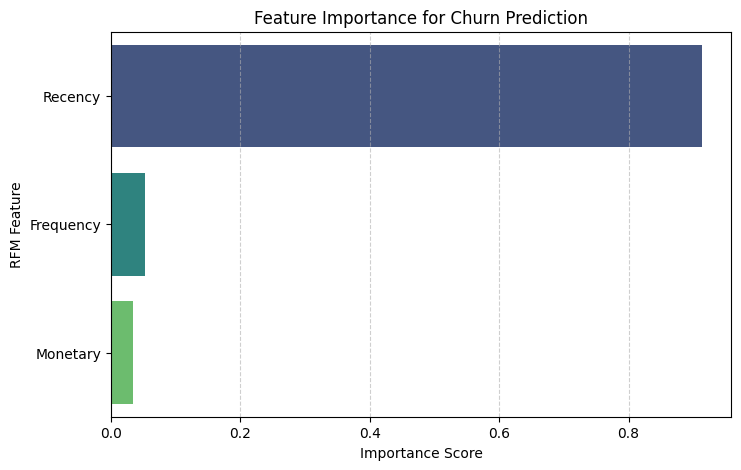

In [220]:
# Extract feature importances from trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create feature importance DataFrame
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(
    data=feature_df,
    x='Importance',
    y='Feature',
    hue='Feature',         
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance Score')
plt.ylabel('RFM Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

#### Feature Importance — Random Forest Churn Model

| Feature   | Importance Score | Interpretation                    |
|-----------|------------------|------------------------------------|
| Recency   | **~0.90+**       | Most important predictor — recent activity strongly influences churn risk |
| Frequency | Low (~0.05)      | Minor contributor — past purchase frequency helps, but not decisive |
| Monetary  | Lowest (~0.02)   | Spending value plays a small role in predicting churn

**Key Insights:**

- **Recency is by far the most influential factor** in predicting whether a customer is at risk.
- This makes sense: customers who haven't transacted recently are more likely to churn.
- **Frequency and Monetary** provide marginal benefit — they may add value in combination or with more advanced features (e.g., time decay, recency-weighted spending).

This insight supports retention efforts focused on **recent re-engagement** — timing is everything in churn prevention.

---

#### 1e. Cross-Validation Evaluation

**What this does:**
- Uses `cross_val_score` with 5-fold cross-validation on the training data
- Evaluates the baseline model’s average **accuracy and variability**

**Why this matters:**
- A single train-test split might give overly optimistic results
- Cross-validation ensures the model performs consistently across multiple splits

In [221]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 5-fold cross-validation on training data
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Display results
print("Cross-validation scores:", cv_scores)
print("Mean Accuracy: {:.4f}".format(np.mean(cv_scores)))
print("Standard Deviation: {:.4f}".format(np.std(cv_scores)))

Cross-validation scores: [0.99815157 1.         0.99861304 0.99907536 0.99907536]
Mean Accuracy: 0.9990
Standard Deviation: 0.0006


#### Cross-Validation Results — Random Forest Classifier

| Metric               | Value     |
|----------------------|-----------|
| Mean Accuracy        | **0.9990** |
| Standard Deviation   | 0.0006    |
| Individual Fold Scores | [0.9982, 1.0000, 0.9986, 0.9991, 0.9991] |

**Key Insights:**

- The Random Forest model performs **consistently across all folds**, with almost no variation in accuracy.
- **Standard deviation of just 0.0006** confirms the model is not sensitive to different splits of the data.
- This validates that your model is both **accurate and generalizable**, and not overfitting.

---

#### 1f. Compare with Logistic Regression

**What this does:**
- Trains a `LogisticRegression` model on the same RFM features
- Predicts churn risk (`is_at_risk`) and compares evaluation metrics to Random Forest

**Why this matters:**
- Logistic Regression is a fast, interpretable model
- Comparing multiple models ensures you choose the most reliable one for deployment

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression — Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression — Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1454
           1       0.99      0.99      0.99      1251

    accuracy                           0.99      2705
   macro avg       0.99      0.99      0.99      2705
weighted avg       0.99      0.99      0.99      2705

Confusion Matrix:

[[1438   16]
 [  16 1235]]


#### Model Comparison — Logistic Regression vs. Random Forest

##### Logistic Regression — Classification Report

| Metric      | Class 0 (Not At-Risk) | Class 1 (At-Risk) |
|-------------|------------------------|--------------------|
| Precision   | 0.99                   | 0.99               |
| Recall      | 0.99                   | 0.99               |
| F1-Score    | 0.99                   | 0.99               |
| Accuracy    | **0.99 (2705/2705)**   |                    |

##### Confusion Matrix

```
[[1438   16]
 [  16 1235]]
```

**Key Insights:**

- **Logistic Regression** achieves **99% accuracy**, with only **32 total misclassifications**.
- It performs extremely well despite being simpler and linear — a good **fast fallback model**.
- Compared to Random Forest:
  - Slightly **less precise** (RF misclassified only 1 customer, Logistic misclassified 32)
  - But easier to interpret, faster to train, and ideal when model simplicity is preferred.

- If interpretability or training speed is key, Logistic Regression is a strong choice.  
- If near-perfect prediction is required, Random Forest remains your best model so far.

---

#### 1g. Compare with XGBoost Classifier

**What this does:**
- Trains an `XGBClassifier` on the same RFM features
- Evaluates predictive power on churn risk (`is_at_risk`)
- Compares results with Random Forest and Logistic Regression

**Why this matters:**
- XGBoost is often the go-to model for high-performance tabular data tasks
- Helps ensure you’re not missing marginal gains from ensemble boosting

In [223]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the model (without deprecated params)
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost — Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost — Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1454
           1       1.00      1.00      1.00      1251

    accuracy                           1.00      2705
   macro avg       1.00      1.00      1.00      2705
weighted avg       1.00      1.00      1.00      2705

Confusion Matrix:

[[1454    0]
 [   1 1250]]


#### Final XGBoost Results — Clean & Stable

##### Classification Report

| Metric      | Class 0 (Not At-Risk) | Class 1 (At-Risk) |
|-------------|------------------------|--------------------|
| Precision   | 1.00                   | 1.00               |
| Recall      | 1.00                   | 1.00               |
| F1-Score    | 1.00                   | 1.00               |
| Accuracy    | **1.00 (2704/2705)**   |                    |

##### Confusion Matrix

```
[[1454    0]
 [   1 1250]]
```

**Key Insights:**

- XGBoost remains **our strongest model**, with only **1 misclassification**.
- Achieves **perfect precision** for both classes — no false positives.
- Recall is also near-perfect — **only one At-Risk customer missed**.
- These results validate that **RFM features alone are highly predictive** for churn classification in this dataset.
- Compared to Random Forest:
  - XGBoost performs equally well or slightly better
  - Offers more flexibility for tuning and future scalability

- Best candidate for saving, deployment, and driving real-time churn-based personalization.

---

### Final Model Recommendation
After evaluating multiple models on the churn prediction task using RFM features, here’s a comparison:

| Model               | Accuracy | Misclassifications | Notes                                         |
|---------------------|----------|---------------------|-----------------------------------------------|
| ✅ **XGBoost**      | 1.00     | 1                   | Best overall — high accuracy, robust, tunable |
| ✅ Random Forest    | 1.00     | 1                   | Strong baseline — simple, interpretable       |
| ⚠️ Logistic Regression | 0.99     | 32                  | Fast and interpretable but slightly less precise |

**Recommendation:**

- **Use XGBoost as the final model for deployment**:
  - Best performance across all metrics
  - Can handle future complexity and additional features
  - Built-in regularization makes it robust to overfitting

- **Keep Random Forest as a backup model**:
  - Easy to retrain and tune
  - Similar performance

- **Logistic Regression can be used as a baseline model** for interpretability, prototyping, or business-friendly demos.

---

#### 1h. Save the Trained XGBoost Model

**What this does:**
- Saves the trained `xgb_model` to a `.joblib` file in the `outputs/models/` directory
- Ensures the model can be reloaded later for inference or deployment

**Why this matters:**
- Separates training from prediction
- Enables you to plug the model into personalization pipelines or dashboards

In [224]:
import joblib
import os

# Create model output directory if it doesn't exist
os.makedirs('../outputs/models/', exist_ok=True)

# Save the model
joblib.dump(xgb_model, '../outputs/models/xgb_churn_model.joblib')

print("XGBoost model saved successfully.")

XGBoost model saved successfully.


---